<a href="https://colab.research.google.com/github/kenichinakanishi/houseplant_classifier/blob/master/Part_2_Training_with_Controlled_Randomness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
# Run once per session
!pip install fastai==2.1.2 -q
!pip install fastcore==1.3.1 -q
!pip install torch==1.7.0 -q
from fastai.basics import *
from fastai.vision.all import *
from fastai.callback.all import *
from fastai.callback.cutmix import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
from fastai.vision.models.xresnet import *
from fastcore.script import *
fastprogress.MAX_COLS = 80

     |████████████████████████████████| 194kB 8.8MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
     |████████████████████████████████| 51kB 4.1MB/s 


In [ ]:
! nvidia-smi #NVIDIA-SMI 455.32.00 Driver Version: 418.67 CUDA Version: 10.1 Tesla V100-SXM2

Sat Nov  7 09:32:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |     10MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
torch.cuda.is_available()

True

In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7411 sha256=1cfb06df69fd14412480b8025d49e67e5bfd926e6a031caed64b08b70cf72487
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil


# Download and Unzip the File

The use of images directly from a google drive is very slow.
This is because even though the drive appears to be direcly attached to our colab instance, in actuality we are dynamically downloading and accessing each image one by one - leading to extremely long training times. 

At this point, I've gone to the directory the image files were downloaded to, zipped them up and placed that master zip file into my google drive for importing and processing. 

In [ ]:
# If your zip file is on your google drive - download it into the current kernel
#!cp '/content/drive/My Drive/Houseplant Classifier/plant_images_deepest_cleaned' 'test' -r

In [ ]:
# If your zip file is on your google drive - download it into the current kernel
!cp '/content/drive/My Drive/Houseplant Classifier/plant_images_database_manualcleanedlosses10.zip' 'plant_images_database_manualcleanedlosses10.zip'
# This code snippet unzips a zip file to a specified destination
!unzip "/content/plant_images_database_manualcleanedlosses10.zip" -d "/content";

Streaming output truncated to the last 5000 lines.
  inflating: /content/plant_images_database_manualcleanedlosses10/Sorghum bicolor/00000225.jpg  
  inflating: /content/plant_images_database_manualcleanedlosses10/Sorghum bicolor/00000226.jpg  
  inflating: /content/plant_images_database_manualcleanedlosses10/Sorghum bicolor/00000227.jpg  
  inflating: /content/plant_images_database_manualcleanedlosses10/Sorghum bicolor/00000228.jpg  
  inflating: /content/plant_images_database_manualcleanedlosses10/Sorghum bicolor/00000229.jpg  
  inflating: /content/plant_images_database_manualcleanedlosses10/Sorghum bicolor/00000230.jpg  
  inflating: /content/plant_images_database_manualcleanedlosses10/Sorghum bicolor/00000231.jpg  
  inflating: /content/plant_images_database_manualcleanedlosses10/Sorghum bicolor/00000232.jpg  
  inflating: /content/plant_images_database_manualcleanedlosses10/Sorghum bicolor/00000233.jpg  
  inflating: /content/plant_images_database_manualcleanedlosses10/Sorghum bi

In [ ]:
# If your zip file is on your google drive - download it into the current kernel
!cp '/content/drive/My Drive/Houseplant Classifier/plant_images_database.zip' 'plant_images_database.zip'
# This code snippet unzips a zip file to a specified destination
!unzip "/content/plant_images_database.zip" -d "/content";

Streaming output truncated to the last 5000 lines.
  inflating: /content/plant_image_database/Stevia rebaudiana/00000420.jpg  
 extracting: /content/plant_image_database/Stevia rebaudiana/00000421.jpg  
  inflating: /content/plant_image_database/Stevia rebaudiana/00000422.jpg  
  inflating: /content/plant_image_database/Stevia rebaudiana/00000423.jpg  
  inflating: /content/plant_image_database/Stevia rebaudiana/00000424.jpg  
  inflating: /content/plant_image_database/Stevia rebaudiana/00000425.jpg  
  inflating: /content/plant_image_database/Stevia rebaudiana/00000426.jpg  
  inflating: /content/plant_image_database/Stevia rebaudiana/00000427.jpg  
  inflating: /content/plant_image_database/Stevia rebaudiana/00000428.jpg  
  inflating: /content/plant_image_database/Stevia rebaudiana/00000429.jpg  
  inflating: /content/plant_image_database/Stevia rebaudiana/00000430.jpg  
  inflating: /content/plant_image_database/Stevia rebaudiana/00000431.jpg  
  inflating: /content/plant_image_dat

# Model Setup

In [ ]:
def random_seed(seed_value, use_cuda):
  '''
  Sets the random seed for numpy, pytorch, python.random and pytorch GPU vars.
  '''
  np.random.seed(seed_value) # Numpy vars
  torch.manual_seed(seed_value) # PyTorch vars
  random.seed(seed_value) # Python
  if use_cuda: # GPU vars
      torch.cuda.manual_seed(seed_value)
      torch.cuda.manual_seed_all(seed_value) 
      torch.backends.cudnn.deterministic = True 
      torch.backends.cudnn.benchmark = False
  print(f'Random state set:{seed_value}, cuda used: {use_cuda}')

In [ ]:
@call_parse
def create_path_df(
      path: Param("Path of images to use", str), 
      pct_images: Param("Fraction of images to use", float)=1,
      shuffle: Param("Shuffle prior to splitting", bool)=False,
      ):
  '''
  Creates a dataframe with respective classes and path to images.
  Can return a subset of those images based on the pct_images.
  By default will return the earliest files in the path.

  Returns:
  ----------
  DataFrame
    Returns a dataframe with Class and Path columns. 
  '''
  from sklearn.utils import shuffle as shuff
  data = []
  for folder in sorted(os.listdir(path)):
      num_files = len(sorted(os.listdir(path+'/'+folder)))
      cut_point = int(num_files*pct_images)
      # Takes the first pct_images from each folder
      if shuffle == True:
        for file in shuff(os.listdir(path+'/'+folder))[:cut_point]:
          data.append((folder, path+folder+'/'+file))
      else:
        for file in sorted(os.listdir(path+'/'+folder))[:cut_point]:
          data.append((folder, path+folder+'/'+file))
  df = pd.DataFrame(data, columns=['Class', 'Path'])
  print(f'Creating path:label dataframe from {path}, using {pct_images*100:.2f}% of the images ({len(df)} images.) Shuffle = {shuffle}.')
  return df

In [ ]:
@call_parse
def stratified_split(
      dataframe: Param("DataFrame created from create_path_df, containing Class and Path columns."), 
      n_splits: Param("Number of folds in split", int)=5,
      shuffle: Param("Shuffle prior to splitting", bool)=True,
      fold: Param("Which fold to use", int)=0,
      random_state: Param("Fix randomness if shuffle==True", int)=101,
      ):
  ''' 
  Prepares a stratified k-fold split from a dataframe with 'Class' and 'Path' by adding an 'is_valid' column.

  Returns:
  ----------
  DataFrame
    Returns the requested stratified k-fold split by adding an 'is_valid' column. 
  '''
  from sklearn.model_selection import StratifiedKFold
  # Create stratified split using sklearn
  print(f'Preparing stratified {n_splits} fold split, random state is {random_state}. Returning fold {fold}.')
  kf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state = random_state)
  X, y = dataframe['Path'], dataframe['Class']
  splits = list(kf.split(X, y))
  # Prepare the selected fold
  fold = fold
  train_df = dataframe.loc[splits[fold][0]]
  val_df = dataframe.loc[splits[fold][1]]
  train_df['is_valid'] = False
  val_df['is_valid'] = True
  df_cnn = train_df.append(val_df)
  # Return the selected fold
  return df_cnn

In [ ]:
@call_parse
def get_dataloader(
      img_path: Param("Path of images to use", str),
      split_path: Param("Path of images to use to pre-define split", str)=None,
      img_size:  Param("Size in pixels", int)=224,
      pct_images: Param("Fraction of images to use", float)=1,
      bs: Param("Batch size", int)=64,
      deterministic: Param("Deterministic learner", bool)=True,
      randomerasing: Param("Random Erasing", str)=None,
      n_splits: Param("Number of folds in split", int)=5,
      shuffle: Param("Shuffle prior to splitting", bool)=True,
      fold: Param("Which fold to use", int)=0,
      ):
  """ 
  Takes in image path and creates a dataloader. 
  If a split_path is defined, uses the entirety of that path to generate a master split, onto which the img_path is joined to defined a pseudo split.  
      
  Returns:
  ----------
  Dataloader
    dls = data.dataloaders(df_cnn_mini, bs=bs)
  """

  # Get file path and labels from the dataframe we set up.
  get_x = lambda x: x['Path']
  get_y = lambda y: y['Class']
  # Define splitting function that reads from a dataframe column.
  def stratifiedsplitter(df):      
      train = df.index[~df['is_valid']].tolist()
      valid = df.index[df['is_valid']].tolist()
      return train,valid   
  # Prepare transforms
    # Image is larger initially (512 px) for later augmentations.
  item_tfms=[RandomResizedCrop(512, min_scale = 0.7)]
    # Batch transformations include a random resized crop to img_size px. 
  batch_tfms=[*aug_transforms(size=img_size), Normalize.from_stats(*imagenet_stats)]
  # Add in randomerasing if necessary.
  if randomerasing != None:
    batch_tfms=[*aug_transforms(size=img_size), Normalize.from_stats(*imagenet_stats), randomerasing]
  # Prepare DataBlock
  data = DataBlock(blocks=(ImageBlock, CategoryBlock),
                    splitter=stratifiedsplitter,            # Stratified train/validation split
                    get_x=get_x,                            # Get the image path from dataframe
                    get_y=get_y,                            # Label from dataframe
                    item_tfms=item_tfms,                    # Crop images to a square
                    batch_tfms=batch_tfms)                  # Normalize the images based on the imagenet stats
  if split_path != None:
    print('Split Path defined, preparing pseudo stratified split.')
    # Create split_df - a dataframe that defines a master split, based on split_path
    df = create_path_df(split_path, pct_images=1)
    split_df = stratified_split(df, n_splits = 5, shuffle = True, random_state = 101, fold = 0)
    split_df['Path']= split_df['Path'].apply(lambda x:img_path+'/'.join(x.split('/')[-2:]))
    # Inner join this reduced dataframe to the previous splits to maintain the same training images
    df_mini = create_path_df(img_path, pct_images=pct_images)
    df_cnn_mini= df_mini.merge(split_df, how = 'inner', on = ['Class','Path'])
  else: 
    # Create a dataframe based on main image path with a (possibly) reduced number of images
    df = create_path_df(img_path, pct_images=pct_images)
    df_cnn_mini = stratified_split(df, n_splits = 5, shuffle = True, random_state = 101, fold = 0)
  # Print some information for a sanity check
  dls = data.dataloaders(df_cnn_mini, bs=bs)
  print(f'We have {dls.c} classes, with a training set of size {len(dls.train_ds)}, and a validation set of size {len(dls.valid_ds)}')
  if split_path != None:
    print(f"The main split has {split_df['is_valid'].describe()['freq']/len(split_df['is_valid'])*100:.2f}% training data with {len(split_df.groupby('Class').count())} classes, the reduced split has {df_cnn_mini['is_valid'].describe()['freq']/len(df_cnn_mini['is_valid'])*100:.2f} % training data, with {len(df_cnn_mini.groupby('Class').count())} classes.")
  return dls

In [ ]:
@call_parse
def create_simple_cnn_learner(
        size:  Param("Size", int)=224,
        bs:    Param("Batch size", int)=64,
        arch:  Param("Architecture", str)='resnet34',
        fp16:  Param("Use mixed precision training", int)=0,
        deterministic: Param("Deterministic learner", bool)=True,
        pretrained: Param("Pretrained architecture", bool)=True,
        pct_images: Param("Percent of images to sue", float)=1,
        img_path: Param("Path of images to use", str)='/content/plant_images_database_manualcleanedlosses10/',
        split_path: Param("Path of images to use to pre-define split", str)=None,
        model_dir: Param("Path to save model", str)='/content/drive/My Drive/Houseplant Classifier/Models/',
        log_name: Param("Name of csv training log", str)='history.csv',
        splitter: Param("Custom splitter", str)=None,
        ):
    # Select optimization function
    opt_func = partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)
    # Set Random Seed
    if deterministic == True:
      random_seed(101,True)
    # Get Dataloader
    dls = get_dataloader(img_size = size, bs = bs, img_path=img_path, split_path=split_path, pct_images=pct_images)
    # Setup activation function and pooling
    model = globals()[arch] 
    # Setup callbacks
    callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback()]
    # Setup Learner
    learn = cnn_learner(dls, 
                        model, 
                        splitter=splitter,
                        pretrained=pretrained,
                        opt_func=opt_func,
                        metrics=[accuracy,top_k_accuracy], 
                        model_dir = model_dir,
                        cbs=callbacks,
                        )
    if fp16: learn = learn.to_fp16()

    return learn

In [ ]:
# Import source of efficientnet models and weights
!pip install geffnet -q
from geffnet import *

@call_parse
def create_cnn_learner(
        size:  Param("Size", int)=224,
        bs:    Param("Batch size", int)=64,
        opt:   Param("Optimizer (adam,rms,sgd,ranger)", str)='adam',
        arch:  Param("Architecture", str)='resnet34',
        fp16:  Param("Use mixed precision training", int)=0,
        deterministic: Param("Deterministic learner", bool)=True,
        pretrained: Param("Pretrained architecture", bool)=True,
        pct_images: Param("Percent of images to sue", float)=1,
        img_path: Param("Path of images to use", str)='/content/plant_images_database_manualcleanedlosses10/',
        split_path: Param("Path of images to use to pre-define split", str)=None,
        model_dir: Param("Path to save model", str)='/content/drive/My Drive/Houseplant Classifier/Models/',
        log_name: Param("Name of csv training log", str)='history.csv',
        splitter: Param("Custom splitter", str)=None,
        sa: Param("Self Attention for XResNet", bool)=False,
        act_cls: Param("Activation class to use", str)='ReLU',
        loss_func: Param("Learner loss function", str)=None,
        mixup: Param("Mixup", str)=None,
        cutmix: Param("Cutmix", str)=None,
        randomerasing: Param("Random Erasing", str)=None,
        ):
    # Select optimization function
    if   opt=='adam'  : opt_func = partial(Adam, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)
    elif opt=='rms'   : opt_func = partial(RMSprop, sqr_mom=0.99, mom=0.0, wd=0.0, decouple_wd=True)
    elif opt=='sgd'   : opt_func = partial(SGD, mom=0.0, wd=0.0, decouple_wd=True)
    elif opt=='ranger': opt_func = partial(ranger, mom=0.95, wd=0.01, eps=1e-06, sqr_mom=0.99, beta=0.0, decouple_wd=True)
    # Get DataLoader
    if deterministic == True:
      random_seed(101,True)
    # Implement RandomErasing
    if randomerasing != None:
      dls = get_dataloader(img_size = size, bs = bs, img_path=img_path, split_path=split_path, pct_images=pct_images, randomerasing=randomerasing)
    else: 
      dls = get_dataloader(img_size = size, bs = bs, img_path=img_path, split_path=split_path, pct_images=pct_images)
    # Setup activation function and pooling
    model = globals()[arch] 
    if ('xresnet' in arch) and act_cls != 'ReLU':
      model = partial(model, act_cls=act_cls, sa=sa, n_out=dls.c)
    elif 'xresnet' in arch:
      model = partial(model, sa=sa, n_out=dls.c)
    elif ('tf_efficientnet' in arch) and act_cls == 'Mish':
      # Change all SwishJit() to Mish() and return an nn.Sequential()
      def effmish(model=model, pretrained=pretrained):
        model = model(pretrained=pretrained)
        model.act1 = Mish()
        model.act2 = Mish()
        for i in range(len(model.blocks)):
          for j in range(len(model.blocks[i])):
            if str(model.blocks[i][j].act1) == 'SwishJit()':
              model.blocks[i][j].act1 = Mish()
            if str(model.blocks[i][j].act2) == 'SwishJit()':
              model.blocks[i][j].act2 = Mish()
            if str(model.blocks[i][j].se.act1) == 'SwishJit()':
              model.blocks[i][j].se.act1 = Mish()
        return nn.Sequential(*model.children())
      model = effmish
    # Setup callbacks
    callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback()]
    if mixup != None:
      mixup = mixup
      callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback(), mixup]
    elif cutmix != None:
      cutmix = cutmix
      callbacks = [CSVLogger(fname=log_name, append=True), ShowGraphCallback(), cutmix]
    # Setup Learner
    learn = cnn_learner(dls, 
                        model, 
                        splitter=splitter,
                        pretrained=pretrained,
                        opt_func=opt_func,
                        metrics=[accuracy,top_k_accuracy], 
                        model_dir = model_dir,
                        loss_func = loss_func,
                        cbs=callbacks,
                        )
    if fp16: learn = learn.to_fp16()

    return learn

In [ ]:
def enumerate_params(learner):
  '''
  Enumerates the unfrozen and frozen parameters for a given learner when called.
  '''
  total_params = sum(p.numel() for p in learner.model.parameters())
  print(f'{total_params:,} total parameters.')
  total_trainable_params = sum(
  p.numel() for p in learner.model.parameters() if p.requires_grad)
  print(f'{total_trainable_params:,} training parameters.')

# Changing Number of Images

## (1) Train Model - 50 Baseline
To compare the effect of a different amount of images for each class, we utilize a simple transfer learning process, freezing the model parameters excepting the head -  then unfreezing for fine-tuning. 

Learning rates will be fixed across each test, and all randomness will be fixed by setting deterministic = True.


In [ ]:
learn = create_simple_cnn_learner(pct_images=1/3, 
                           deterministic=True, 
                           size=224, 
                           img_path ='/content/plant_image_database/',
                           split_path = '/content/plant_image_database/',
                           log_name = '50baseline.csv')

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_image_database/, using 33.33% of the images (25900 images.) Shuffle = False.
We have 518 classes, with a training set of size 20744, and a validation set of size 5156
The main split has 80.00% training data with 518 classes, the reduced split has 80.09 % training data, with 518 classes.


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


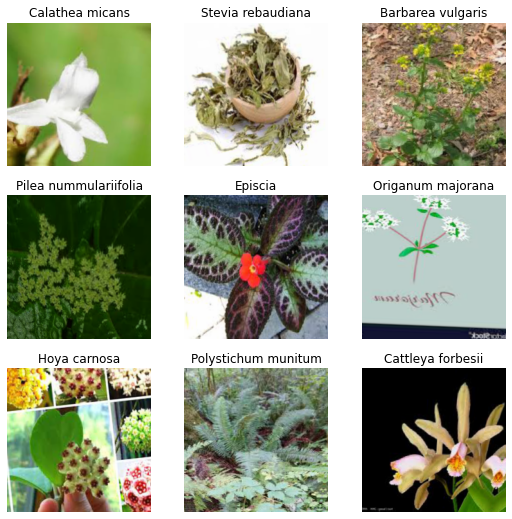

In [ ]:
# Running this or not will change the result of the later training
learn.dls.show_batch(max_n=9)

In [ ]:
def baseline_fit(learn):
  print(f'Freezing model body')
  learn.freeze()
  enumerate_params(learn)
  learn.fit_one_cycle(10, 1e-02)
  learn.save('stage-1-50images')
  print(f'Unfreezing model body')
  learn.unfreeze()
  enumerate_params(learn)
  learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
  learn.save('stage-2-50images')

Freezing model body
22,077,248 total parameters.
809,600 training parameters.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.786026,3.658269,0.253491,0.481575,01:37
1,3.886513,3.361133,0.272692,0.532971,01:37
2,3.399748,3.233385,0.295772,0.561870,01:36
3,3.034216,2.833203,0.358029,0.642746,01:37
4,2.691675,2.554358,0.408844,0.694143,01:36
5,2.336424,2.248014,0.473429,0.744957,01:35
6,2.080412,2.033792,0.523468,0.778704,01:34
7,1.785816,1.924339,0.547517,0.793445,01:33
8,1.574085,1.870228,0.563615,0.802172,01:33
9,1.447911,1.867857,0.565555,0.806051,01:33


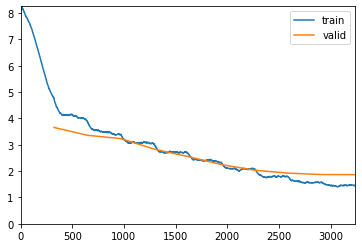

Unfreezing model body
22,077,248 total parameters.
22,077,248 training parameters.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.400647,1.859393,0.566912,0.805857,01:36
1,1.492402,1.866928,0.558766,0.804694,01:38
2,1.444147,1.830827,0.570597,0.811870,01:35
3,1.383600,1.787688,0.577192,0.818852,01:36
4,1.275754,1.782833,0.578549,0.820209,01:39
5,1.184259,1.732947,0.592320,0.827967,01:40
6,1.137838,1.721446,0.598526,0.827579,01:39
7,1.078299,1.712942,0.596974,0.826998,01:39
8,1.026448,1.705679,0.594259,0.829131,01:39
9,1.002879,1.702503,0.598526,0.829325,01:42


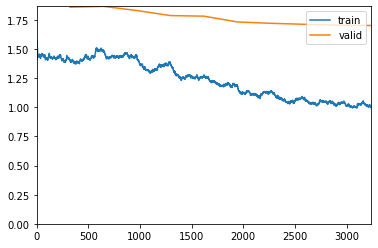

In [ ]:
baseline_fit(learn)

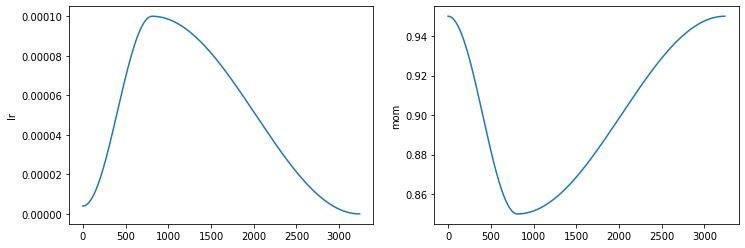

In [ ]:
learn.recorder.plot_sched()

## (1) Train Model - 100 Images
Here we do a standard transfer learning process ontop of a Resnet34 architecture.


In [ ]:
learn = create_simple_cnn_learner(pct_images=2/3, 
                           deterministic=True, 
                           size=224, 
                           img_path ='/content/plant_image_database/',
                           split_path = '/content/plant_image_database/',
                           log_name = '100baseline.csv')

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_image_database/, using 66.67% of the images (51800 images.) Shuffle = False.
We have 518 classes, with a training set of size 41489, and a validation set of size 10311
The main split has 80.00% training data with 518 classes, the reduced split has 80.09 % training data, with 518 classes.


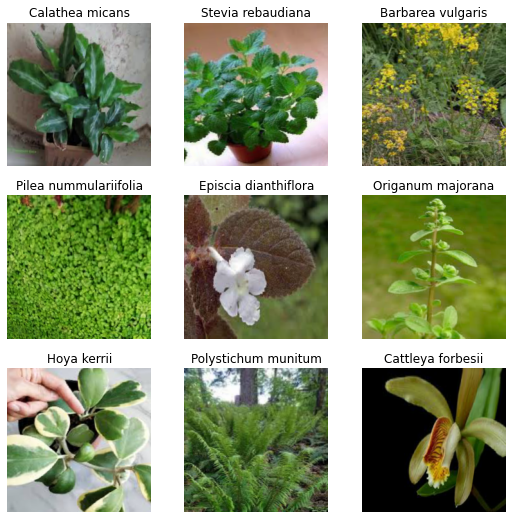

In [ ]:
learn.dls.show_batch(max_n=9)

In [ ]:
def baseline_fit(learn):
  print(f'Freezing model body')
  learn.freeze()
  enumerate_params(learn)
  learn.fit_one_cycle(10, 1e-02)
  learn.save('stage-1-100images')
  print(f'Unfreezing model body')
  learn.unfreeze()
  enumerate_params(learn)
  learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
  learn.save('stage-2-100images')

Freezing model body
22,077,248 total parameters.
809,600 training parameters.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.169097,3.449406,0.278053,0.537484,03:08
1,3.712699,3.448648,0.264184,0.534284,03:09
2,3.341756,3.087302,0.322568,0.597420,03:08
3,3.089060,2.680132,0.399670,0.670449,03:09
4,2.823198,2.489789,0.439046,0.703618,03:07
5,2.595534,2.233592,0.482688,0.750849,03:05
6,2.351362,2.101927,0.511105,0.767821,03:08
7,2.068988,1.979901,0.539327,0.788284,03:10
8,1.931944,1.919095,0.551450,0.797013,03:10
9,1.873287,1.912181,0.553099,0.798371,03:08


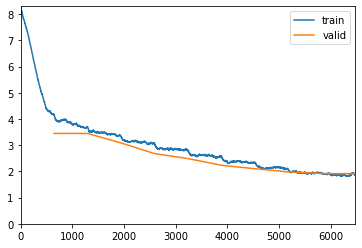

Unfreezing model body
22,077,248 total parameters.
22,077,248 training parameters.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.823425,1.904233,0.553293,0.798759,03:13
1,1.883080,1.887416,0.557366,0.803414,03:12
2,1.822209,1.850257,0.563379,0.809718,03:12
3,1.745411,1.814466,0.574047,0.813015,03:12
4,1.665377,1.778453,0.579672,0.821550,03:14
5,1.580253,1.736647,0.588013,0.826593,03:15
6,1.456398,1.709815,0.596353,0.828533,03:14
7,1.444224,1.693339,0.598099,0.829405,03:14
8,1.396114,1.686299,0.600136,0.832218,03:13
9,1.371058,1.685613,0.600427,0.829987,03:16


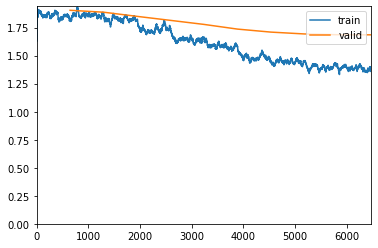

In [ ]:
baseline_fit(learn)

## (1) Train Model - 150 Images
Here we do a standard transfer learning process ontop of a Resnet34 architecture.


In [ ]:
learn = create_simple_cnn_learner(pct_images=1, 
                           deterministic=True, 
                           size=224, 
                           img_path ='/content/plant_image_database/',
                           split_path = '/content/plant_image_database/',
                           log_name = '150baseline.csv')

Random state set:101, cuda used: True
Split Path defined, preparing pseudo stratified split.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
Preparing stratified 5 fold split, random state is 101. Returning fold 0.
Creating path:label dataframe from /content/plant_image_database/, using 100.00% of the images (77700 images.) Shuffle = False.
We have 518 classes, with a training set of size 62160, and a validation set of size 15540
The main split has 80.00% training data with 518 classes, the reduced split has 80.00 % training data, with 518 classes.


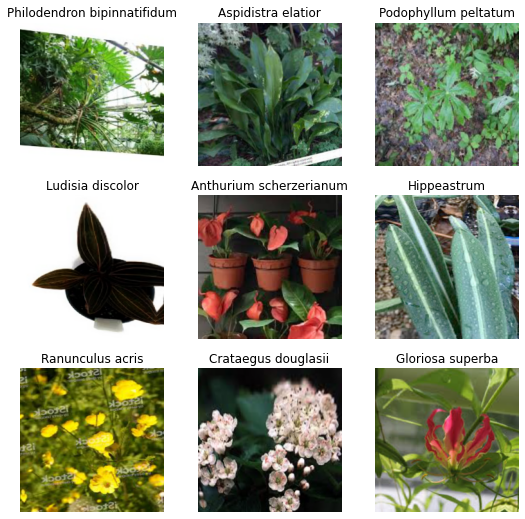

In [ ]:
learn.dls.show_batch(max_n=9)

In [ ]:
def baseline_fit(learn):
  print(f'Freezing model body')
  learn.freeze()
  enumerate_params(learn)
  learn.fit_one_cycle(10, 1e-02)
  learn.save('stage-1-150images')
  print(f'Unfreezing model body')
  learn.unfreeze()
  enumerate_params(learn)
  learn.fit_one_cycle(10, lr_max=slice(1e-5, 1e-4))
  learn.save('stage-2-150images')

Freezing model body
22,077,248 total parameters.
809,600 training parameters.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,4.071423,3.440247,0.287130,0.536680,04:46
1,3.734393,3.590937,0.255598,0.505534,04:46
2,3.428155,3.221294,0.311647,0.575290,04:49
3,3.188388,2.825658,0.382368,0.645560,04:49
4,2.955096,2.614466,0.422329,0.687001,04:48
5,2.798677,2.403419,0.463449,0.722522,04:45
6,2.516254,2.251868,0.501030,0.742021,04:44
7,2.419482,2.150810,0.518790,0.756178,04:45
8,2.208199,2.089839,0.535135,0.767568,04:49
9,2.165035,2.079320,0.537387,0.768983,04:53


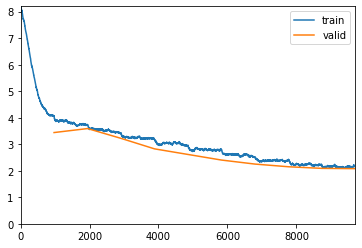

Unfreezing model body
22,077,248 total parameters.
22,077,248 training parameters.


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,2.148573,2.068102,0.537773,0.770592,05:03
1,2.168235,2.045281,0.541377,0.773295,05:03
2,2.050922,1.988636,0.547748,0.782690,05:03
3,1.971222,1.951105,0.555470,0.791055,05:02
4,1.927993,1.904646,0.566345,0.794530,05:03
5,1.841317,1.872777,0.573616,0.801030,05:03
6,1.700697,1.844240,0.578700,0.803925,05:03
7,1.690239,1.823820,0.580695,0.806435,05:03
8,1.653259,1.814788,0.583333,0.808687,05:03
9,1.642427,1.811778,0.584170,0.807336,05:05


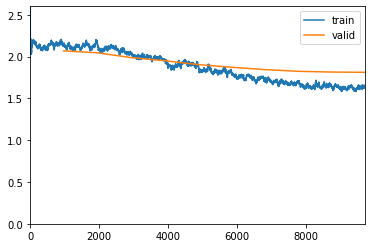

In [ ]:
baseline_fit(learn)